In [ ]:
!pip install keras-unet-collection

     |████████████████████████████████| 67 kB 3.2 MB/s 


In [ ]:
import tensorflow as tf
import os
import sys
import numpy as np
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
import time
import tensorflow_hub as hub
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


resizing training images and masks


100%|██████████| 379/379 [03:04<00:00,  2.05it/s]


Done!


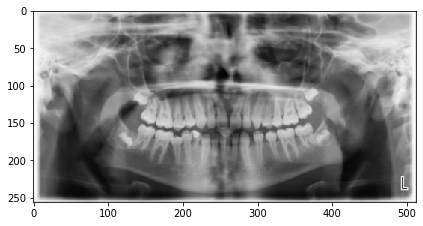

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


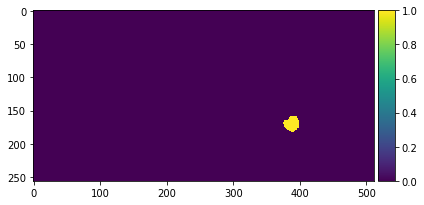

In [ ]:
#pre-processing and check all images and masks correctly read
IMG_WIDTH = 512
IMG_HEIGHT = 256
IMG_CHANNELS = 1
 
DATA_PATH = '/content/drive/MyDrive/Colab_Notebooks/GP/dataset/training_set/images/' # Training original images
Mask_path1= '/content/drive/MyDrive/Colab_Notebooks/GP/dataset/training_set/segmentation_map/'   # Segmentation Map

seed = 42
random.seed = seed
np.random.seed = seed
 
image_ids = next(os.walk(DATA_PATH))[2]

len(image_ids)
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('resizing training images and masks')
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
  try:
    path = DATA_PATH 
    img = imread(path+ id_)[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(Mask_path1))[2]:
      if mask_file==id_:
        #print(Mask_path1 +  mask_file)
        mask_ = imread(Mask_path1 + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y[n] = mask
  except:
    print('error')

x_train=X 
y_train=Y

print('Done!')

image_x = random.randint(0, len(image_ids))#i added -1 temp
imshow(x_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [ ]:
#test images
TEST_PATH = '/content/drive/MyDrive/Colab_Notebooks/GP/dataset/testing_set/images/'

test_ids = next(os.walk(TEST_PATH))[2]

len(test_ids)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sizes_test=[]
print('resizing training images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH 
  img = imread(path+ id_)[:,:]
  sizes_test.append([img.shape[0],img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n]=img 

resizing training images


100%|██████████| 218/218 [00:52<00:00,  4.18it/s]


In [ ]:
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8

In [ ]:
help(models.att_unet_2d)

Help on function att_unet_2d in module keras_unet_collection._model_att_unet_2d:

att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='attunet')
    Attention U-net with an optional ImageNet backbone
    
    att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', 
                atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
                backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='att-unet')
                
    ----------
    Oktay, O., Schlemper, J., Folgoc, L.L., Lee, M., Heinrich, M., Misawa, K., Mori, K., McDonagh, S., Hammerla, N.Y., Kainz, B. 
    and Glocker, B., 2018. Attention u-

In [ ]:
model_att_unet = models.att_unet_2d((256, 512, 1), filter_num=[16,32,64, 128, 256], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           atten_activation='ReLU', attention='add', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=True, unpool=True, 
                           backbone=None, weights=None, 
                           freeze_backbone=False, freeze_batch_norm=False, 
                           name='attunet')


model_att_unet.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy', losses.dice_coef])

print(model_att_unet.summary())

Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 attunet_down0_0 (Conv2D)       (None, 256, 512, 16  144         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 attunet_down0_0_bn (BatchNorma  (None, 256, 512, 16  64         ['attunet_down0_0[0][0]']        
 lization)                      )                                                     

In [ ]:
start3 = datetime.now() 
callbacks= [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')]
att_unet_history = model_att_unet.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_split=0.1, 
                    shuffle=False,
                    epochs=50, callbacks=callbacks)

stop3 = datetime.now()
#Execution time of the model 
execution_time_att_Unet = stop3-start3
print("Attention UNet execution time is: ", execution_time_att_Unet)

Epoch 1/50
43/43 [==============================] - 44s 655ms/step - loss: 0.2484 - accuracy: 0.9840 - dice_coef: 0.0140 - val_loss: 0.5141 - val_accuracy: 0.9816 - val_dice_coef: 0.0112
Epoch 2/50
43/43 [==============================] - 22s 512ms/step - loss: 0.1445 - accuracy: 0.9941 - dice_coef: 0.0262 - val_loss: 0.3783 - val_accuracy: 0.9937 - val_dice_coef: 0.0127
Epoch 3/50
43/43 [==============================] - 22s 516ms/step - loss: 0.1032 - accuracy: 0.9957 - dice_coef: 0.0481 - val_loss: 0.1616 - val_accuracy: 0.9942 - val_dice_coef: 0.0142
Epoch 4/50
43/43 [==============================] - 22s 515ms/step - loss: 0.0752 - accuracy: 0.9972 - dice_coef: 0.0910 - val_loss: 0.1109 - val_accuracy: 0.9942 - val_dice_coef: 0.0117
Epoch 5/50
43/43 [==============================] - 22s 512ms/step - loss: 0.0566 - accuracy: 0.9977 - dice_coef: 0.1343 - val_loss: 0.0730 - val_accuracy: 0.9970 - val_dice_coef: 0.0758
Epoch 6/50
43/43 [==============================] - 22s 512ms/ste

In [ ]:
t = time.time()
my_keras_model_filepath = '3rdm_att_UNet_50epochs.h5'.format(int(t))
print(my_keras_model_filepath)
model_att_unet.save(my_keras_model_filepath)

3rdm_att_UNet_50epochs.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
att_unet_history_df = pd.DataFrame(att_unet_history.history) 

In [ ]:
with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f) 

In [ ]:
history = att_unet_history

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
model = model_att_unet

In [ ]:
idx = random.randint(0, len(x_train))
preds_train = model_att_unet.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model_att_unet.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model_att_unet.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

7/7 [==============================] - 9s 1s/step


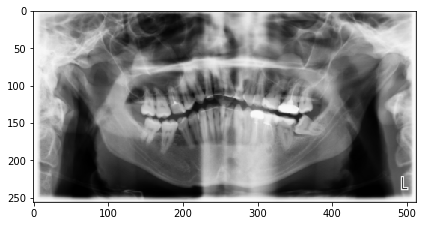

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


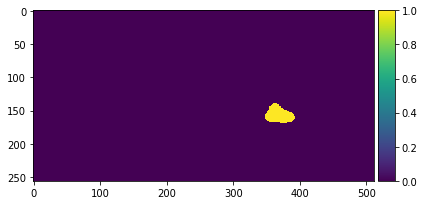

In [ ]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

#Support References:


*   https://github.com/bnsreenu/python_for_microscopists/blob/master/227_mito_segm_using_models_from_Keras_Unet_collection.py
*   https://pypi.org/project/keras-unet-collection/
*   https://github.com/yingkaisha/keras-unet-collection/blob/main/examples/user_guide_models.ipynb
*   https://www.youtube.com/watch?v=ZoJuhRbzEiM






